# Clustering con Wavelets + K-Means

Usamos **Discrete Wavelet Transform (DWT)** en lugar de FFT para extraer características.

### ¿Por qué Wavelets?
- FFT captura solo información de frecuencia (pierde localización temporal)
- DWT captura información **tiempo-frecuencia** simultáneamente
- Útil para señales no estacionarias donde el contenido frecuencial cambia en el tiempo

**Wavelet usada:** Daubechies 4 (`db4`) - común en análisis de vibraciones

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]

sys.path.append('../utils')
from clustering_utils import load_paired_signals_for_clustering
from wavelet_utils import apply_wavelet_to_pairs, extract_wavelet_features
from metrics_logger import ClusteringMetricsLogger

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

RESULTS_FILE = '../../results/clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print("Setup completado")

Setup completado


## 1. Carga de Datos

In [10]:
# Cargar pares (S2, S1)
paired_data = load_paired_signals_for_clustering(
    signals_dir='../../data/Signals_Raw/',
    labels_csv='../../data/nivel_damage.csv',
    base_specimens_only=True,
    target_length=60000,
    verbose=False
)
print(f"Cargados {len(paired_data)} pares de señales")

Cargados 30 pares de señales


## 2. Aplicar DWT y Extraer Features

La DWT descompone la señal en:
- **cA** (aproximación): componentes de baja frecuencia
- **cD1, cD2, ...** (detalles): componentes de alta frecuencia en cada nivel

Extraemos energía, media absoluta y desviación estándar de cada nivel.

In [11]:
# Aplicar DWT (Daubechies 4, 5 niveles)
wavelet_data = apply_wavelet_to_pairs(paired_data, wavelet='db4', level=5)

# Extraer features de los coeficientes
features_matrix, features_df, feature_names = extract_wavelet_features(wavelet_data, verbose=False)

print(f"\nFeatures extraídas: {features_matrix.shape}")
print(f"  {features_matrix.shape[0]} especímenes x {features_matrix.shape[1]} características")

🔄 Aplicando DWT (db4, nivel=5) a cada par...
✅ DWT aplicado a 30 pares


Features extraídas: (30, 108)
  30 especímenes x 108 características


In [12]:
# Normalizar
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

# Metadata
labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

# Para métricas extrínsecas
label_mapping = {'N1': 0, 'N2': 1, 'N3': 2}
mask_con_etiqueta = labels_real != 'Sin_etiqueta'
labels_real_numeric = np.array([label_mapping[l] for l in labels_real[mask_con_etiqueta]])

print(f"Etiquetados: {mask_con_etiqueta.sum()} de {len(labels_real)}")

Etiquetados: 14 de 30


## 3. K-Means Clustering

In [13]:
# K-Means con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_normalized)

# PCA para visualización
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print(f"Varianza explicada PCA: {pca.explained_variance_ratio_.sum():.1%}")

Varianza explicada PCA: 78.6%


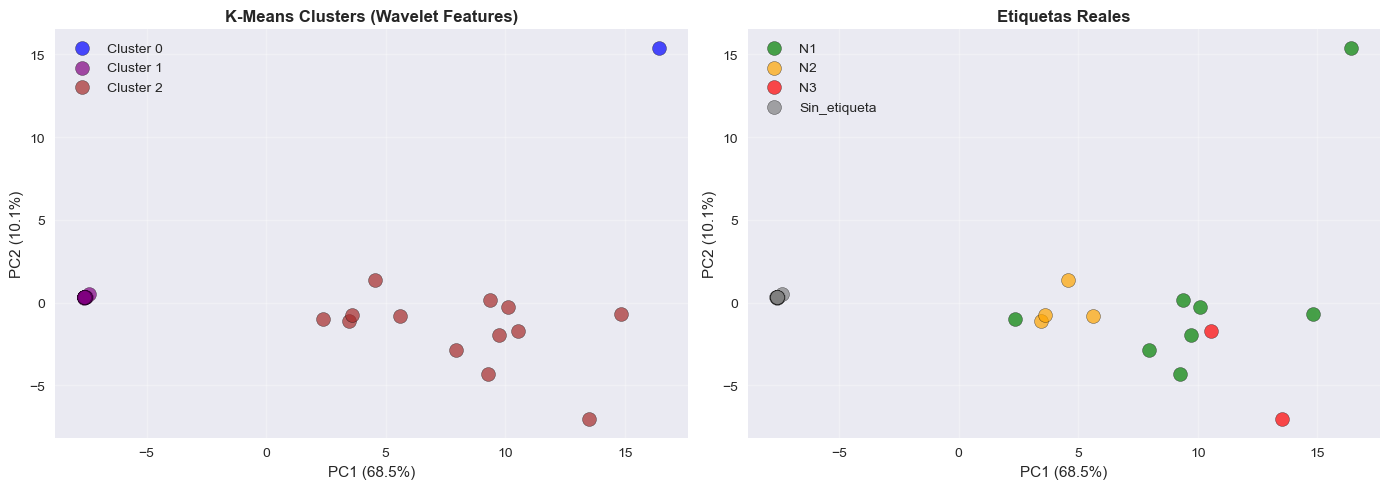


Cluster vs Nivel de Daño:
Cluster       0   1  2
Nivel                 
N1            1   0  7
N2            0   0  4
N3            0   0  2
Sin_etiqueta  0  16  0


In [6]:
# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clusters
colors_cluster = {0: 'blue', 1: 'purple', 2: 'brown'}
for c in range(3):
    mask = cluster_labels == c
    axes[0].scatter(features_pca[mask, 0], features_pca[mask, 1],
                    c=colors_cluster[c], label=f'Cluster {c}', s=100, alpha=0.7, edgecolors='black')
axes[0].set_title('K-Means Clusters (Wavelet Features)', fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Etiquetas reales
colors_real = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}
for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() > 0:
        axes[1].scatter(features_pca[mask, 0], features_pca[mask, 1],
                        c=colors_real[nivel], label=nivel, s=100, alpha=0.7, edgecolors='black')
axes[1].set_title('Etiquetas Reales', fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCluster vs Nivel de Daño:")
print(pd.crosstab(labels_real, cluster_labels, rownames=['Nivel'], colnames=['Cluster']))

## 4. Métricas y Registro

In [14]:
# Métricas intrínsecas
inertia = kmeans.inertia_
silhouette = silhouette_score(features_normalized, cluster_labels)
davies_bouldin = davies_bouldin_score(features_normalized, cluster_labels)
calinski = calinski_harabasz_score(features_normalized, cluster_labels)

# Métricas extrínsecas
cluster_labels_etiq = cluster_labels[mask_con_etiqueta]
ari = adjusted_rand_score(labels_real_numeric, cluster_labels_etiq)
nmi = normalized_mutual_info_score(labels_real_numeric, cluster_labels_etiq)
homogeneity = homogeneity_score(labels_real_numeric, cluster_labels_etiq)
completeness = completeness_score(labels_real_numeric, cluster_labels_etiq)
v_measure = v_measure_score(labels_real_numeric, cluster_labels_etiq)

print("Métricas Wavelet + K-Means (k=3):")
print(f"  Inertia:        {inertia:.2f}")
print(f"  Silhouette:     {silhouette:.4f}")
print(f"  Davies-Bouldin: {davies_bouldin:.4f}")
print(f"  Calinski:       {calinski:.2f}")
print(f"  ARI:            {ari:.4f}")
print(f"  NMI:            {nmi:.4f}")

# Registrar
logger.log_experiment(
    experiment_id="wavelet_kmeans_k3_db4",
    notebook_name="4_clustering_wavelet_kmeans",
    algorithm="kmeans",
    frequency_transform="wavelet",
    n_clusters=3,
    pca_dims=2,
    feature_set="wavelet_db4_level5",
    inertia=inertia,
    silhouette_score=silhouette,
    davies_bouldin_index=davies_bouldin,
    calinski_harabasz_score=calinski,
    adjusted_rand_index=ari,
    normalized_mutual_info=nmi,
    homogeneity=homogeneity,
    completeness=completeness,
    v_measure=v_measure,
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="Wavelet db4 level=5 + K-Means k=3"
)

Métricas Wavelet + K-Means (k=3):
  Inertia:        902.99
  Silhouette:     0.6512
  Davies-Bouldin: 0.4796
  Calinski:       34.94
  ARI:            -0.0755
  NMI:            0.0693
🔄 Experimento actualizado: 4_clustering_wavelet_kmeans | kmeans | wavelet (ID: wavelet_kmeans_k3_db4)


## 5. Comparación con FFT

In [15]:
# Cargar resultados previos
df_experiments = pd.read_csv(RESULTS_FILE)

# Filtrar experimentos relevantes
mask = df_experiments['algorithm'] == 'kmeans'
df_kmeans = df_experiments[mask][['experiment_id', 'frequency_transform', 'silhouette_score', 'davies_bouldin_index', 'adjusted_rand_index', 'normalized_mutual_info']]

print("Comparación K-Means: FFT vs Wavelet")
print(df_kmeans.to_string(index=False))

Comparación K-Means: FFT vs Wavelet
          experiment_id frequency_transform  silhouette_score  davies_bouldin_index  adjusted_rand_index  normalized_mutual_info
   fft_kmeans_k3_simple                 fft          0.324292              0.985912            -0.015314                0.181826
fft_kmeans_k3_simple_3d                 fft          0.324292              0.985912            -0.015314                0.181826
  wavelet_kmeans_k3_db4             wavelet          0.651184              0.479614            -0.075472                0.069284


In [16]:
print(f"\nExperimentos registrados en: {RESULTS_FILE}")


Experimentos registrados en: ../../results/clustering_experiments.csv
